In [123]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)


data = pd.read_csv('crime.csv')
df_or = pd.DataFrame(data)


#Some basic data cleaning here (ASK MUKESH ABOUT FURTHER DATA CLEANING)

# this is a good command to make all column names upper/lower case
# df.columns = map(str.lower, df.columns), not needed here as I am renaming columns manually


#Remove empty columns of data here (NaN)
df_or = df_or.dropna(subset = ['Population', 'City'])
df_or = df_or.drop('Unnamed: 13', axis=1)
df_or = df_or.drop(df_or.columns[4], axis = 1) #'Rape (revised definition)1'

#Remove commas from the numbers in all data, standardize all the numbers for the future
df_or = df_or.replace(',', '', regex=True)

#Renaming columns for consistency and ease of typing
df = df_or.rename({'Robbery':'robbery',
               df_or.columns[0]:'city',
               df_or.columns[1]:'population', 
               df_or.columns[2]:'violent crime',
               df_or.columns[3]:'murder',
               df_or.columns[4]:'rape',
               df_or.columns[6]:'assault',
               df_or.columns[7]:'property crime',
               df_or.columns[8]:'burglary',
               df_or.columns[9]:'larceny',
               df_or.columns[10]:'motor vehicle theft',
               df_or.columns[11]:'arson'}, 
               axis='columns')

#This is 1 line of code that changes all columns to numeric (except the columns I exclude)
#This also fills NAN values to 0, this removes decimals from the data and allows us to 
#perform math functions on the data since it is not strings anymore

df.loc[:, df.columns != 'city'] = df.loc[:, df.columns != 'city'].apply(pd.to_numeric, 
                                        errors='coerce').fillna(0, downcast='infer')

In [124]:
from scipy import stats

z = np.abs(stats.zscore(df.loc[:, df.columns != 'city']))
# get indices of outliers
outliers= list(np.where(z > 3)[0])
# drop them
df= df.drop(outliers)

#Now for the assignment portion:

# As per instructions: Create new feature of population^2
df['population^2'] = np.power(df['population'], 2)

#as per instructions for robbery and murder: 
# "For this model, please use these variables to create categorical 
# features where values greater than 0 are coded 1, and values equal to 0 are coded 0."" 
df.murder[df.murder >= 1] = 1
df.murder[df.murder < 1] = 0

df.robbery[df.robbery >= 1] = 1
df.robbery[df.robbery < 1] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [121]:
# 𝑃𝑟𝑜𝑝𝑒𝑟𝑡𝑦𝑐𝑟𝑖𝑚𝑒=𝛼+𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛+𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛2+𝑀𝑢𝑟𝑑𝑒𝑟+𝑅𝑜𝑏𝑏𝑒𝑟𝑦
#Do a linear regression that deals with ^ 

In [147]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property crime'].values.reshape(-1, 1)
X = df[['murder','robbery','population^2']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[4.40008387e+02 2.48146267e+02 9.48152541e-08]]

Intercept: 
 [41.42692661]

R-squared:
0.5292995374951746


In [106]:
# This shows us that the base rate of property crime (intercept) is about 40 instances, 
# regardless of the murder, robbery, or population of that city

#Murder appears to have the greatest impact of increased property damage
#Robbery also has as significant impact but not nearly as much as murder
#Population does not appear to affect property crime in any signifcant way

#Our R-Sqaured is .986 which means the model explains about 98% of the variance in property crime

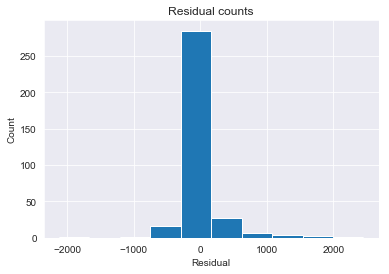

In [126]:
predicted = regr.predict(X).ravel()
actual = df['property crime']

sns.set_style('darkgrid')
# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

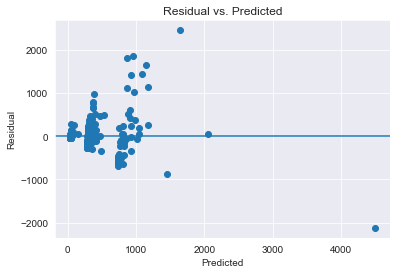

In [127]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


In [148]:
correlation_matrix = X.corr()
display(correlation_matrix)

,murder,robbery,population^2
murder,1.000,0.302,0.329
robbery,0.302,1.000,0.184
population^2,0.329,0.184,1.000
